# Imports

In [ ]:
!pip install scikit-multilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.8 MB/s eta 0:00:00


In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import requests
import pandas as pd
import os
import seaborn as sns
from datetime import datetime
import dateutil.parser
import numpy as np
import ast
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, pairwise
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.model_selection import iterative_train_test_split
from matplotlib import pyplot as plt
from scipy import stats
import warnings

# GetData

In [ ]:
def getTwitchData():
  twitchData = []
  for root, dirs, files in os.walk('/content/drive/MyDrive/MIE368 Project/Data/TwitchData/'):
    for file in files:
      filePath = os.path.join(root,file)
      twitchData.append(pd.read_csv(filePath, usecols=["Game","Watch time (mins)","Peak viewers"]))
  twitchDF = pd.concat(twitchData, ignore_index=True)

  twitchDF = twitchDF.set_index('Game')
  twitchDF = twitchDF.drop(index=['Just Chatting','Music','Poker','ASMR','Art','Sports','Politics','Chess','Software and Game Development'] ,errors='ignore')
  twitchDF = twitchDF.reset_index()
  twitchDF['enjoyment'] = (twitchDF['Watch time (mins)']/60)/twitchDF['Peak viewers']
  twitchDF['Top'] = (twitchDF['enjoyment']>=13.2) *2
  twitchDF['Mid'] = (twitchDF['enjoyment']>=5.5)*(twitchDF['enjoyment']<13.2) *1
  twitchDF['enjoyment'] = twitchDF['Top'] + twitchDF['Mid']
  # twitchDF['Stream time (hours)'] = twitchDF['Stream time (mins)']/60
  twitchDF = twitchDF.drop(columns=['Watch time (mins)',"Peak viewers",'Top','Mid'])
  return twitchDF

In [ ]:
def getSteamData():
  setDate = datetime.strptime("2023-10-25", "%Y-%m-%d").date()
  SteamDF = pd.read_csv('/content/drive/MyDrive/MIE368 Project/Data/steam.csv', usecols=[
      'appid',
      'name',
      'release_date',
  ])
  SteamDF['release_date'] = SteamDF['release_date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").date())
  SteamDF['days'] = (setDate - SteamDF['release_date']).dt.days

  return SteamDF

In [ ]:
def getMetacriticScores():
  metacriticDF = pd.read_csv('/content/drive/MyDrive/MIE368 Project/Data/steam_app_data.csv', usecols=[
    'steam_appid',
    'metacritic',
  ])
  metacriticDF = metacriticDF.dropna()
  metacriticDF = metacriticDF.drop_duplicates()
  metacriticDF['metacritic'] = metacriticDF['metacritic'].apply(ast.literal_eval)
  metacriticDF['metacritic'] = [int(i['score']) for i in metacriticDF['metacritic']]
  metacriticDF['metacritic'] = (metacriticDF['metacritic']>72) *1

  return metacriticDF

In [ ]:
def getSteamSpyData():
  SteamSpyDF = pd.read_csv('/content/drive/MyDrive/MIE368 Project/Data/steamspy_data.csv',usecols=[
    'appid',
    'positive',
    'negative',
    # 'owners',
    # 'average_forever',
    # 'average_2weeks',
    # 'median_forever',
    # 'median_2weeks',
    'price',
    # 'initialprice',
    # 'discount',
    # 'ccu',
    ])
  # SteamSpyDF['owners'] = [int(i.split(' .. ')[-1].replace(',','')) for i in SteamSpyDF['owners']]
  return SteamSpyDF

In [ ]:
def getCombSteamData():
  SteamSpyDF = getSteamSpyData()
  SteamDF = getSteamData()
  metaDF = getMetacriticScores()

  combDF = pd.merge(SteamDF,metaDF,how='left',left_on='appid',right_on='steam_appid').drop(columns = 'steam_appid')
  combDF = pd.merge(combDF,SteamSpyDF,how='inner',left_on='appid',right_on='appid')
  combDF = combDF.drop(columns = 'release_date')
  combDF['ratio'] = (combDF['positive'])/(combDF['negative']+(combDF['positive']))
  # combDF = combDF.drop(columns=['positive','negative'])
  #combDF['metacritic'] = combDF['metacritic'].fillna(combDF['metacritic'].mean())
  return combDF

In [ ]:
def getSteamSpyTagData():
  tagDF = pd.read_csv('/content/drive/MyDrive/MIE368 Project/Data/steamspy_tag_data.csv')
  return tagDF

In [ ]:
def getSteamSpyOneHotTagData():
  tagDF = getSteamSpyTagData()
  tagDF.index = tagDF.appid
  tagDF = tagDF.drop(columns='appid')
  tagDF = (tagDF > 0) *1
  tagDF = tagDF.reset_index(drop=0)
  return tagDF

In [ ]:
def getTagCombDF():
  tagDF = getSteamSpyOneHotTagData()
  combDF = getCombSteamData()
  tagCombDF = pd.merge(combDF,tagDF,how='inner',left_on='appid',right_on='appid')
  return tagCombDF

# Training Functions

In [ ]:
def trainModel(df,modelType,target,hyperparams,verbose = True):
  X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = target), df[target], test_size=0.30, random_state=1)

  mdl = modelType(**hyperparams)
  mdl.fit(X_train,y_train)
  if not verbose: return mdl

  train_score = mdl.score(X_train, y_train)
  test_score = mdl.score(X_test, y_test)
  print(f'The train score is {train_score:.3f} and the test score is {test_score:.3f}\n')
  print(cross_validate(mdl, df.drop(columns = target), df[target], cv=5)['test_score'].mean())

  y_pred = mdl.predict(X_test)
  cfm = confusion_matrix(y_true=y_test, y_pred=y_pred)
  ax = sns.heatmap(cfm, annot=True)
  ax.set(xlabel='Predicted', ylabel='Actual');
  plt.show()
  return mdl

# Prediction Functions

In [ ]:
def getTwitchSteamDFs():
  tagSteamData = getTagCombDF()
  twitchDF = getTwitchData()

  TwitchSteamDF = pd.merge(tagSteamData,twitchDF,how='left',left_on='name',right_on='Game').drop(columns='Game').drop_duplicates('appid')
  return TwitchSteamDF

In [ ]:
def predictMetaScores(TwitchSteamDF):
  metaDFExisting = TwitchSteamDF.copy().dropna(subset = ["metacritic"])
  metaDFMissing = TwitchSteamDF.copy()[TwitchSteamDF["metacritic"].isnull()]
  metaDFRatio = metaDFMissing.copy()[metaDFMissing['positive']+metaDFMissing['negative']>5]
  metaDFtags = metaDFMissing.copy()[metaDFMissing['positive']+metaDFMissing['negative']<=5]

  metaRatioMdl = trainModel(TwitchSteamDF[['ratio','metacritic']].dropna(),DecisionTreeClassifier,'metacritic',{"random_state":0, "max_depth":7, 'min_samples_split':0.05, 'splitter':'random'}, False)
  metaTagsMdl = trainModel(TwitchSteamDF[tags+['metacritic']].dropna(),LogisticRegression,'metacritic',{'max_iter':4000,'C':0.01}, False)

  metaDFRatio['metacritic'] = metaRatioMdl.predict(metaDFRatio[['ratio']])
  metaDFtags['metacritic'] = metaTagsMdl.predict(metaDFtags[tags])
  # metaDFMissing['metacritic'] = metaTagsMdl.predict(metaDFMissing[tags])

  metaTagDFFinal = pd.concat([metaDFExisting,metaDFRatio,metaDFtags]).sort_index()
  # metaTagDFFinal = pd.concat([metaDFExisting,metaDFMissing]).sort_index()
  return metaTagDFFinal

In [ ]:
def predictEnjoyment(TwitchSteamDF):
  TwitchSteamDF_Existing = TwitchSteamDF.copy().dropna()
  TwitchSteamDF_Missing = TwitchSteamDF.copy()[TwitchSteamDF["enjoyment"].isnull()]
  Mdl = trainModel(TwitchSteamDF_Existing.drop(columns = ['appid','name']),RandomForestClassifier,'enjoyment',{"random_state":0, "max_depth":8, 'max_samples': 0.7,'min_samples_split':0.05, 'n_estimators':17},False)
  # Mdl = trainModel(TwitchSteamDF_Existing.drop(columns = ['appid','name']),LogisticRegression,'enjoyment',{'max_iter':4000,'C':0.001},False)
  #print(TwitchSteamDF_Missing)
  TwitchSteamDF_Missing['enjoyment'] = Mdl.predict(TwitchSteamDF_Missing.drop(columns = ['appid','name','enjoyment']))

  TwitchSteamFinal = pd.concat([TwitchSteamDF_Existing,TwitchSteamDF_Missing]).sort_index()
  return TwitchSteamFinal
  #return TwitchSteamDF_Existing, Mdl

In [ ]:
def getOutputDF(inputDF):
  inputDF = predictMetaScores(inputDF)
  inputDF = predictEnjoyment(inputDF)
  outputDF = inputDF[["appid",'name','metacritic','enjoyment']]
  tagsDF = inputDF[['appid']+tags]
  return outputDF,tagsDF

In [ ]:
def getReleasingGames():
  #only get the columns we want, if we dont take metacritic and enjoyment columns when we combine they will be Nan
  releasingGames = pd.read_excel('/content/drive/MyDrive/MIE368 Project/Data/releasing_games.xlsx',usecols=['appid','name','days','positive','negative','price','ratio']+tags)
  return releasingGames

# Similarity Functions

In [ ]:
def getPlayerVector(tagDF,appids):
  playerDF = tagDF[tagDF.appid.isin(appids)]
  playerDF = playerDF.set_index('appid')
  playerDF = playerDF.transpose()
  playerDF[0] = playerDF.mean(axis=1)
  return playerDF[[0]].transpose().reset_index()

In [ ]:
def addPlayerToInputs(tagsDF,PlayerVector):
  tagsDF = tagsDF[tagsDF['appid']!=0]
  tagsDF = pd.concat([tagsDF,PlayerVector],axis=0)
  return tagsDF

In [ ]:
def getSimilarityArray(tagDF: pd.DataFrame, combDFapps: pd.DataFrame , appid: int, playedGames: list = None):
  if playedGames:
    PlayerVector = getPlayerVector(tagDF,playedGames)
    tagDF = addPlayerToInputs(tagDF,PlayerVector)
    pv = pd.DataFrame({'appid':0,'name':'Player vector'},index = [0])
    combDFapps = pd.concat([combDFapps,pv],axis=0)
  tagDF = pd.merge(combDFapps,tagDF,how='inner',left_on='appid',right_on='appid')
  tagDF.index = tagDF.appid
  targetName = tagDF.loc[appid]['name']
  tagDF = tagDF.drop(columns=['appid','name'])
  print(targetName)
  targetArray = tagDF.loc[appid]

  sim = pairwise.cosine_similarity(tagDF,[targetArray])
  sim = pd.DataFrame(sim,index = tagDF.index)
  sim = pd.merge(combDFapps,sim,how='inner',left_on='appid',right_on='appid')
  sim.index = sim.appid
  sim[0] = (~sim.index.isin(playedGames))*sim[0]
  sim = sim.sort_values(0, ascending=False)[sim['appid']!=0]
  sim = sim.drop(columns = 'appid')
  return sim

# Main

In [ ]:
twitch = ['Peak viewers', 'Peak channels', 'Streamers', 'Average viewers','Average channels', 'Average viewer ratio', 'Watch time (hours)','Stream time (hours)']
steam = ['appid', 'name', 'days', 'metacritic', 'positive', 'negative', 'owners', 'average_forever', 'average_2weeks', 'price', 'ccu', 'ratio']
tags = ['1980s', '1990s', '2.5d', '2d', '2d_fighter', '360_video', '3d', '3d_platformer', '3d_vision', '4_player_local', '4x', '6dof', 'atv', 'abstract', 'action', 'action_rpg', 'action_adventure', 'addictive', 'adventure', 'agriculture', 'aliens', 'alternate_history', 'america', 'animation_&_modeling', 'anime', 'arcade', 'arena_shooter', 'artificial_intelligence', 'assassin', 'asynchronous_multiplayer', 'atmospheric', 'audio_production', 'bmx', 'base_building', 'baseball', 'based_on_a_novel', 'basketball', 'batman', 'battle_royale', 'beat_em_up', 'beautiful', 'benchmark', 'bikes', 'blood', 'board_game', 'bowling', 'building', 'bullet_hell', 'bullet_time', 'crpg', 'capitalism', 'card_game', 'cartoon', 'cartoony', 'casual', 'cats', 'character_action_game', 'character_customization', 'chess', 'choices_matter', 'choose_your_own_adventure', 'cinematic', 'city_builder', 'class_based', 'classic', 'clicker', 'co_op', 'co_op_campaign', 'cold_war', 'colorful', 'comedy', 'comic_book', 'competitive', 'conspiracy', 'controller', 'conversation', 'crafting', 'crime', 'crowdfunded', 'cult_classic', 'cute', 'cyberpunk', 'cycling', 'dark', 'dark_comedy', 'dark_fantasy', 'dark_humor', 'dating_sim', 'demons', 'design_&_illustration', 'destruction', 'detective', 'difficult', 'dinosaurs', 'diplomacy', 'documentary', 'dog', 'dragons', 'drama', 'driving', 'dungeon_crawler', 'dungeons_&_dragons', 'dynamic_narration', 'dystopian_', 'early_access', 'economy', 'education', 'emotional', 'epic', 'episodic', 'experience', 'experimental', 'exploration', 'fmv', 'fps', 'faith', 'family_friendly', 'fantasy', 'fast_paced', 'feature_film', 'female_protagonist', 'fighting', 'first_person', 'fishing', 'flight', 'football', 'foreign', 'free_to_play', 'funny', 'futuristic', 'gambling', 'game_development', 'gamemaker', 'games_workshop', 'gaming', 'god_game', 'golf', 'gore', 'gothic', 'grand_strategy', 'great_soundtrack', 'grid_based_movement', 'gun_customization', 'hack_and_slash', 'hacking', 'hand_drawn', 'hardware', 'heist', 'hex_grid', 'hidden_object', 'historical', 'hockey', 'horror', 'horses', 'hunting', 'illuminati', 'indie', 'intentionally_awkward_controls', 'interactive_fiction', 'inventory_management', 'investigation', 'isometric', 'jrpg', 'jet', 'kickstarter', 'lego', 'lara_croft', 'lemmings', 'level_editor', 'linear', 'local_co_op', 'local_multiplayer', 'logic', 'loot', 'lore_rich', 'lovecraftian', 'mmorpg', 'moba', 'magic', 'management', 'mars', 'martial_arts', 'massively_multiplayer', 'masterpiece', 'match_3', 'mature', 'mechs', 'medieval', 'memes', 'metroidvania', 'military', 'mini_golf', 'minigames', 'minimalist', 'mining', 'mod', 'moddable', 'modern', 'motocross', 'motorbike', 'mouse_only', 'movie', 'multiplayer', 'multiple_endings', 'music', 'music_based_procedural_generation', 'mystery', 'mystery_dungeon', 'mythology', 'nsfw', 'narration', 'naval', 'ninja', 'noir', 'nonlinear', 'nudity', 'offroad', 'old_school', 'on_rails_shooter', 'online_co_op', 'open_world', 'otome', 'parkour', 'parody_', 'party_based_rpg', 'perma_death', 'philisophical', 'photo_editing', 'physics', 'pinball', 'pirates', 'pixel_graphics', 'platformer', 'point_&_click', 'political', 'politics', 'pool', 'post_apocalyptic', 'procedural_generation', 'programming', 'psychedelic', 'psychological', 'psychological_horror', 'puzzle', 'puzzle_platformer', 'pve', 'pvp', 'quick_time_events', 'rpg', 'rpgmaker', 'rts', 'racing', 'real_time_tactics', 'real_time', 'real_time_with_pause', 'realistic', 'relaxing', 'remake', 'replay_value', 'resource_management', 'retro', 'rhythm', 'robots', 'rogue_like', 'rogue_lite', 'romance', 'rome', 'runner', 'sailing', 'sandbox', 'satire', 'sci_fi', 'science', 'score_attack', 'sequel', 'sexual_content', 'shoot_em_up', 'shooter', 'short', 'side_scroller', 'silent_protagonist', 'simulation', 'singleplayer', 'skateboarding', 'skating', 'skiing', 'sniper', 'snow', 'snowboarding', 'soccer', 'software', 'software_training', 'sokoban', 'souls_like', 'soundtrack', 'space', 'space_sim', 'spectacle_fighter', 'spelling', 'split_screen', 'sports', 'star_wars', 'stealth', 'steam_machine', 'steampunk', 'story_rich', 'strategy', 'strategy_rpg', 'stylized', 'submarine', 'superhero', 'supernatural', 'surreal', 'survival', 'survival_horror', 'swordplay', 'tactical', 'tactical_rpg', 'tanks', 'team_based', 'tennis', 'text_based', 'third_person', 'third_person_shooter', 'thriller', 'time_attack', 'time_management', 'time_manipulation', 'time_travel', 'top_down', 'top_down_shooter', 'touch_friendly', 'tower_defense', 'trackir', 'trading', 'trading_card_game', 'trains', 'transhumanism', 'turn_based', 'turn_based_combat', 'turn_based_strategy', 'turn_based_tactics', 'tutorial', 'twin_stick_shooter', 'typing', 'underground', 'underwater', 'unforgiving', 'utilities', 'vr', 'vr_only', 'vampire', 'video_production', 'villain_protagonist', 'violent', 'visual_novel', 'voice_control', 'voxel', 'walking_simulator', 'war', 'wargame', 'warhammer_40k', 'web_publishing', 'werewolves', 'western', 'word_game', 'world_war_i', 'world_war_ii', 'wrestling', 'zombies', 'e_sports']

In [ ]:
TwitchSteamDF = getTwitchSteamDFs()

In [ ]:
TwitchSteamDF

,appid,name,days,metacritic,positive,negative,price,ratio,1980s,1990s,...,web_publishing,werewolves,western,word_game,world_war_i,world_war_ii,wrestling,zombies,e_sports,enjoyment
0,10,Counter-Strike,8393,1.0,124534,3339,999.0,0.973888,1,1,...,0,0,0,0,0,0,0,0,1,2.0
1,20,Team Fortress Classic,8973,NaN,3318,633,499.0,0.839787,0,1,...,0,0,0,0,0,0,0,0,0,2.0
2,30,Day of Defeat,7482,1.0,3416,398,499.0,0.895648,0,0,...,0,0,0,0,1,1,0,0,0,1.0
3,40,Deathmatch Classic,8181,NaN,1273,267,499.0,0.826623,0,0,...,0,0,0,0,0,0,0,0,0,NaN
4,50,Half-Life: Opposing Force,8759,NaN,5250,288,499.0,0.947996,0,1,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27098,1065230,Room of Pandora,1645,NaN,3,0,254.0,1.000000,0,0,...,0,0,0,0,0,0,0,0,0,NaN
27099,1065570,Cyber Gun,1646,NaN,8,1,119.0,0.888889,0,0,...,0,0,0,0,0,0,0,0,0,NaN
27100,1065650,Super Star Blast,1645,NaN,0,1,424.0,0.000000,0,0,...,0,0,0,0,0,0,0,0,0,NaN
27101,1066700,New Yankee 7: Deer Hunters,1652,NaN,2,0,699.0,1.000000,0,0,...,0,0,0,0,0,0,0,0,0,NaN


Predict and Fill Data

In [ ]:
outputDF,tagsDF = getOutputDF(TwitchSteamDF)

In [ ]:
outputDF

,appid,name,metacritic,enjoyment
0,10,Counter-Strike,1.0,2.0
1,20,Team Fortress Classic,1.0,2.0
2,30,Day of Defeat,1.0,1.0
3,40,Deathmatch Classic,1.0,1.0
4,50,Half-Life: Opposing Force,1.0,1.0
...,...,...,...,...
27098,1065230,Room of Pandora,0.0,0.0
27099,1065570,Cyber Gun,1.0,0.0
27100,1065650,Super Star Blast,0.0,0.0
27101,1066700,New Yankee 7: Deer Hunters,0.0,0.0


In [ ]:
tagsDF

,appid,1980s,1990s,2.5d,2d,2d_fighter,360_video,3d,3d_platformer,3d_vision,...,warhammer_40k,web_publishing,werewolves,western,word_game,world_war_i,world_war_ii,wrestling,zombies,e_sports
0,10,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,20,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
3,40,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,50,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27098,1065230,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27099,1065570,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
27100,1065650,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27101,1066700,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Calculate Similarity

In [ ]:
SimDF = getSimilarityArray(tagsDF,outputDF[["appid",'name']],0,[322330,294100,203770,594570,446800,281990,960090,42960,440,552990])
SimDF[0].sort_index() #To Access similarity values in array form for all games.

Player vector


<ipython-input-20-704a7333cc46>:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sim = sim.sort_values(0, ascending=False)[sim['appid']!=0]


appid
10         0.326568
20         0.300787
30         0.451589
40         0.271763
50         0.403914
             ...   
1065230    0.115299
1065570    0.166420
1065650    0.199704
1066700    0.133136
1069460    0.133136
Name: 0, Length: 27075, dtype: float64

Search for game:

In [ ]:
outputDF[outputDF['name'].str.contains('Warship')]

,appid,name,metacritic,enjoyment
11915,552990,World of Warships,1.0,2.0
24140,918620,Warships 3D,1.0,0.0


All Games

In [ ]:
#Get Releasing Games
ReleasingGames = getReleasingGames()
#Get Names and IDs of releasing games
ReleasingGamesList = ReleasingGames[['appid','name']]

In [ ]:
#Combine Releasing games with main df
AllGames = pd.concat([TwitchSteamDF,ReleasingGames])
FinalOutputDF,AllTagsDF = getOutputDF(AllGames) # Fillin Metacritic and Enjoyment scores and get the outputDF and tagsDF that include all games

In [ ]:
#Calculate Similarity For a player against ALL games
SimDF = getSimilarityArray(AllTagsDF,                                                             #Full Tag DF with All the games
                           FinalOutputDF[["appid",'name']],                                       #List of Names and appid for all the games
                           0,                                                                     #Appid to calculate similarity to, if for player, put 0
                           [322330,294100,203770,594570,446800,281990,960090,42960,440,552990])  #List of appids that the player owns/plays, this is a part of my own library with games such as BTD6, Total War, Stellaris, CK3 Etc.

SimDF

Player vector


<ipython-input-20-704a7333cc46>:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sim = sim.sort_values(0, ascending=False)[sim['appid']!=0]


,name,0
appid,,
394360,Hearts of Iron IV,0.713294
34030,Total War: NAPOLEON – Definitive Edition,0.704700
236850,Europa Universalis IV,0.704700
397340,SimplePlanes,0.687513
232890,Stronghold Crusader 2,0.687513
...,...,...
15910,Luxor Amun Rising,0.000000
837380,DeoVR Video Player,0.000000
42960,Victoria II,0.000000


In [ ]:
#Calculating player similarity for a subset of games, can provide either a subset of the tagDF or a subset of the GameList DF

SimDF = getSimilarityArray(AllTagsDF,                                                             #Full Tag DF with All the games
                           ReleasingGamesList,                                                    ##List of Names and appid for RELEASING games
                           0,                                                                     #Appid to calculate similarity to, if for player, put 0
                           [322330,294100,203770,594570,446800,281990,960090,42960,440,552990])   #List of appids that the player owns/plays, this is a part of my own library with games such as BTD6, Total War, Stellaris Etc.

SimDF

Player vector


<ipython-input-20-704a7333cc46>:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sim = sim.sort_values(0, ascending=False)[sim['appid']!=0]


,name,0
appid,,
1150000,Felvidek,0.314777
1120000,Nightingale (early access),0.300787
1170000,Life By You,0.294491
1180000,Like a Dragon: Infinite Wealth,0.277198
1100000,Helldivers 2,0.275583
1200000,Tomb Raider I-III Remastered,0.269032
1220000,Destiny 2: The Final Shape,0.264218
1110000,Banishers: Ghosts of New Eden,0.261407
1140000,Wrath: Aeon of Ruin,0.258051


In [ ]:
#Cem's Code that selects 100 random games as owned/played games
gamesOwnedCombDF = list(outputDF.appid.sample(n=100, random_state = 1).copy()) # We only need the appids as a list

In [ ]:
#Calculating player similarity for a subset of 100 random games with releasing games:
SimDF = getSimilarityArray(AllTagsDF,                    #Full Tag DF with All the games
                           ReleasingGamesList,           #List of Names and appid for RELEASING games
                           0,                            #Appid to calculate similarity to, if for player, put 0
                           gamesOwnedCombDF)             #List of appids that the player owns/plays, this is a part of my own library with games such as BTD6, Total War, Stellaris Etc.

SimDF

Player vector


<ipython-input-20-704a7333cc46>:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sim = sim.sort_values(0, ascending=False)[sim['appid']!=0]


,name,0
appid,,
1050000,Enshrouded,0.253493
1110000,Banishers: Ghosts of New Eden,0.251740
1200000,Tomb Raider I-III Remastered,0.244827
1180000,Like a Dragon: Infinite Wealth,0.242974
1210000,The Political Machine 2024,0.235636
1150000,Felvidek,0.233060
1130000,Promenade,0.218656
1120000,Nightingale (early access),0.218340
1100000,Helldivers 2,0.217813


In [ ]:
SimDF[0].sort_index() #To Access similarity values in array form for all games.

appid
1050000    0.253493
1060000    0.148421
1070000    0.153890
1080000    0.192937
1090000    0.172375
1100000    0.217813
1110000    0.251740
1120000    0.218340
1130000    0.218656
1140000    0.168127
1150000    0.233060
1160000    0.215310
1170000    0.183937
1180000    0.242974
1190000    0.208449
1200000    0.244827
1210000    0.235636
1220000    0.170821
1230000    0.195176
Name: 0, dtype: float64

In [ ]:
FinalOutputDF

,appid,name,metacritic,enjoyment
0,10,Counter-Strike,1.0,2.0
0,1050000,Enshrouded,1.0,2.0
1,1060000,Tekken 8,1.0,2.0
1,20,Team Fortress Classic,1.0,2.0
2,30,Day of Defeat,1.0,1.0
...,...,...,...,...
27098,1065230,Room of Pandora,0.0,0.0
27099,1065570,Cyber Gun,1.0,0.0
27100,1065650,Super Star Blast,0.0,0.0
27101,1066700,New Yankee 7: Deer Hunters,0.0,0.0


In [ ]:
ReleasingGamesMetacritic = pd.merge(FinalOutputDF.drop(columns = ['name']),ReleasingGamesList,on="appid")['metacritic'].to_list()
ReleasingGamesEnjoyment = pd.merge(FinalOutputDF.drop(columns = ['name']),ReleasingGamesList,on="appid")['enjoyment'].to_list()
SimilarityList = SimDF[0].sort_index().to_list()
GameNames = pd.merge(FinalOutputDF.drop(columns = ['name']),ReleasingGamesList,on="appid")['name'].to_list()
PriceList = getReleasingGames()['price'].to_list()

In [ ]:
!pip install gurobipy
import gurobipy as gp
from gurobipy import GRB
import math
import calendar

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 47.2 MB/s eta 0:00:00


In [ ]:
def initialIP(metaScore, popularity, similarity, price, cashAtHand, lengthOfArray, printBool, names, alpha, beta, omega):
  m = gp.Model('IPModel')
  m.Params.LogToConsole =  0
  x = m.addVars(lengthOfArray, vtype = GRB.BINARY, name="games")
  m.update()
  m.setObjective((gp.quicksum(alpha*x[i]*similarity[i]+beta*x[i]*popularity[i]+omega*x[i]*metaScore[i] for i in range(lengthOfArray))), GRB.MAXIMIZE)
  m.addConstr(gp.quicksum(x[i]*price[i] for i in range(lengthOfArray)) <= cashAtHand)
  # Potential Ideas:
  # Only one game per genre
  # Popularity and metascore both in constraints instead
  cost = 0
  m.optimize()
  optimalSolution = []
  j = 0
  for v in x.values():
    optimalSolution.append([names[j], v.X])
    j = j + 1
  if (printBool is True):
    i = 0
    for v in x.values():
      if v.X == 1:
        print("{}: Buy".format(names[i]))
        cost = cost + price[i]

      if v.X != 1:
        print("{}: Don't Buy".format(names[i]))
      i = i + 1

  return m.getObjective().getValue(), cost, optimalSolution

In [ ]:
initialIP(ReleasingGamesMetacritic, ReleasingGamesEnjoyment, SimilarityList, PriceList, 20000, len(PriceList), True, GameNames, 5, 0.5, 1)

Restricted license - for non-production use only - expires 2025-11-24
Enshrouded: Buy
Tekken 8: Don't Buy
Palworld: Buy
Suicide Squad: Kill the Justice League: Don't Buy
Persona 3 Reload: Don't Buy
Helldivers 2: Don't Buy
Banishers: Ghosts of New Eden: Don't Buy
Nightingale (early access): Buy
Promenade: Don't Buy
Wrath: Aeon of Ruin: Buy
Felvidek: Buy
Homeworld 3: Don't Buy
Life By You: Don't Buy
Like a Dragon: Infinite Wealth: Don't Buy
Jujutsu Kaisen Cursed Clash: Don't Buy
Tomb Raider I-III Remastered: Buy
The Political Machine 2024: Buy
Destiny 2: The Final Shape: Don't Buy
Eiyuden Chronicle: Hundred Heroes: Don't Buy


(21.536862368474495,
 19693,
 [['Enshrouded', 1.0],
  ['Tekken 8', 0.0],
  ['Palworld', 1.0],
  ['Suicide Squad: Kill the Justice League', 0.0],
  ['Persona 3 Reload', 0.0],
  ['Helldivers 2', 0.0],
  ['Banishers: Ghosts of New Eden', 0.0],
  ['Nightingale (early access)', 1.0],
  ['Promenade', 0.0],
  ['Wrath: Aeon of Ruin', 1.0],
  ['Felvidek', 1.0],
  ['Homeworld 3', 0.0],
  ['Life By You', 0.0],
  ['Like a Dragon: Infinite Wealth', 0.0],
  ['Jujutsu Kaisen Cursed Clash', 0.0],
  ['Tomb Raider I-III Remastered', 1.0],
  ['The Political Machine 2024', 1.0],
  ['Destiny 2: The Final Shape', 0.0],
  ['Eiyuden Chronicle: Hundred Heroes', 0.0]])

In [ ]:
# Greedy Algorithm for Knapsack
def greedyKnapsack(metaScore, popularity, similarity, price, cashAtHand, gameList, names, alpha, beta, omega):
  objectiveList = []
  objective = 0
  for i in gameList:
    objectiveList.append(omega*metaScore[i] + beta*popularity[i] + alpha*similarity[i])
  gamesSelected = []
  keepGoing = True
  while keepGoing:
    index = gameList.index(max(gameList))
    if price[gameList.index(max(gameList))] > cashAtHand:
      gameList.pop(index)
      objectiveList.pop(index)
    else:
      cashAtHand = cashAtHand-price[index]
      gamesSelected.append(index)
      gameList.pop(index)
      objective = objective + objectiveList[index]
      objectiveList.pop(index)
    if len(gameList) == 0:
      break
  #gameNames = []
  for i in gamesSelected:
    #gameNames.append(names[i])
    print(names[i])
  return objective, cashAtHand

In [ ]:
gamesList = list(range(0, len(PriceList)))
greedyKnapsack(ReleasingGamesMetacritic, ReleasingGamesEnjoyment, SimilarityList, PriceList, 20000, gamesList, GameNames, 5, 0.5, 1)

Eiyuden Chronicle: Hundred Heroes
Destiny 2: The Final Shape
The Political Machine 2024
Tomb Raider I-III Remastered
Life By You


(14.151985174461498, 1305)

In [ ]:
daysLeft = [abs(number) for number in getReleasingGames()['days'].to_list()]
monthsLeft = [math.floor(number/30) for number in daysLeft]
gamesEachMonth = []
for i in range(min(monthsLeft), max(monthsLeft)+1):
  monthGames = []
  for j in range(len(monthsLeft)):
    if monthsLeft[j] == i:
      monthGames.append(j)
  gamesEachMonth.append(monthGames)

In [ ]:
def monthlyKnapsackIP(gamesMonthly):
  objective = 0
  cashAtHand = 20000
  optimalSolutions = []
  for month in range(len(gamesMonthly)):
    monthlyGamesMetacritic, monthlyGamesEnjoyment, monthlySimilarityList, monthlyPriceList, monthlyNames = [], [], [], [], []
    for game in gamesMonthly[month]:
      monthlyGamesMetacritic.append(ReleasingGamesMetacritic[game]), monthlyGamesEnjoyment.append(ReleasingGamesEnjoyment[game]), monthlySimilarityList.append(SimilarityList[game]), monthlyPriceList.append(PriceList[game]), monthlyNames.append(GameNames[game])
    obj, monthlyCost, optimalSolution = initialIP(monthlyGamesMetacritic, monthlyGamesEnjoyment, monthlySimilarityList, monthlyPriceList, cashAtHand, len(monthlyPriceList), True, monthlyNames, 5, 0.5, 1)
    cashAtHand = cashAtHand-monthlyCost
    objective = objective+obj
    optimalSolutions.append(optimalSolution)
  return objective, optimalSolutions

In [ ]:
def monthlyKnapsackGreedy(gamesMonthly):
  objective = 0
  cashAtHand = 20000
  for month in range(len(gamesMonthly)):
    monthlyGamesMetacritic, monthlyGamesEnjoyment, monthlySimilarityList, monthlyPriceList, monthlyNames = [], [], [], [], []
    for game in gamesMonthly[month]:
      monthlyGamesMetacritic.append(ReleasingGamesMetacritic[game]), monthlyGamesEnjoyment.append(ReleasingGamesEnjoyment[game]), monthlySimilarityList.append(SimilarityList[game]), monthlyPriceList.append(PriceList[game]), monthlyNames.append(GameNames[game])
    if len(gamesMonthly[month]) != 0:
      obj, cashAtHand = greedyKnapsack(monthlyGamesMetacritic, monthlyGamesEnjoyment, monthlySimilarityList, monthlyPriceList, cashAtHand, list(range(len(gamesMonthly[month]))), monthlyNames, 5, 0.5, 1)
      objective = objective + obj
  return objective

In [ ]:
monthlyKnapsackIP(gamesEachMonth)

Jujutsu Kaisen Cursed Clash: Buy
Enshrouded: Buy
Tekken 8: Don't Buy
Palworld: Don't Buy
Suicide Squad: Kill the Justice League: Don't Buy
Persona 3 Reload: Don't Buy
Helldivers 2: Don't Buy
Banishers: Ghosts of New Eden: Don't Buy
Like a Dragon: Infinite Wealth: Buy
Tomb Raider I-III Remastered: Buy
Nightingale (early access): Don't Buy
Promenade: Don't Buy
Wrath: Aeon of Ruin: Don't Buy
Felvidek: Don't Buy
Homeworld 3: Don't Buy
Life By You: Don't Buy
The Political Machine 2024: Don't Buy
Destiny 2: The Final Shape: Don't Buy
Eiyuden Chronicle: Hundred Heroes: Don't Buy


(12.748713309564803,
 [[['Jujutsu Kaisen Cursed Clash', 1.0]],
  [['Enshrouded', 1.0],
   ['Tekken 8', 0.0],
   ['Palworld', 0.0],
   ['Suicide Squad: Kill the Justice League', 0.0],
   ['Persona 3 Reload', 0.0],
   ['Helldivers 2', 0.0],
   ['Banishers: Ghosts of New Eden', 0.0],
   ['Like a Dragon: Infinite Wealth', 1.0],
   ['Tomb Raider I-III Remastered', 1.0]],
  [['Nightingale (early access)', 0.0],
   ['Promenade', 0.0],
   ['Wrath: Aeon of Ruin', 0.0],
   ['Felvidek', 0.0],
   ['Homeworld 3', 0.0],
   ['Life By You', 0.0],
   ['The Political Machine 2024', 0.0],
   ['Destiny 2: The Final Shape', 0.0]],
  [],
  [['Eiyuden Chronicle: Hundred Heroes', 0.0]]])

In [ ]:
monthlyKnapsackGreedy(gamesEachMonth)

Jujutsu Kaisen Cursed Clash
Tomb Raider I-III Remastered
Like a Dragon: Infinite Wealth
Helldivers 2


12.570312306021584

In [ ]:

objectives, optimalSolutions = [], []
nTrials = 1000
for i in range(nTrials):
  daysLeftSimulation = []
  for days in daysLeft:
    daysLeftSimulation.append(np.random.poisson(days))
  monthsLeftSimulation = [math.floor(number/30) for number in daysLeftSimulation]
  gamesEachMonthSimulation = []
  for i in range(min(monthsLeftSimulation), max(monthsLeftSimulation)+1):
    monthGamesSimulation = []
    for j in range(len(monthsLeftSimulation)):
      if monthsLeftSimulation[j] == i:
        monthGamesSimulation.append(j)
    gamesEachMonthSimulation.append(monthGamesSimulation)
  objective, optimalSolution = monthlyKnapsackIP(gamesEachMonthSimulation)
  objectives.append(objective), optimalSolutions.append(optimalSolution)

Streaming output truncated to the last 5000 lines.
The Political Machine 2024: Don't Buy
Destiny 2: The Final Shape: Don't Buy
Eiyuden Chronicle: Hundred Heroes: Don't Buy
Enshrouded: Buy
Tekken 8: Buy
Jujutsu Kaisen Cursed Clash: Buy
Palworld: Don't Buy
Suicide Squad: Kill the Justice League: Don't Buy
Persona 3 Reload: Don't Buy
Helldivers 2: Don't Buy
Nightingale (early access): Don't Buy
Promenade: Don't Buy
Like a Dragon: Infinite Wealth: Don't Buy
Tomb Raider I-III Remastered: Buy
Banishers: Ghosts of New Eden: Don't Buy
Wrath: Aeon of Ruin: Don't Buy
Felvidek: Don't Buy
Homeworld 3: Don't Buy
Life By You: Don't Buy
The Political Machine 2024: Don't Buy
Destiny 2: The Final Shape: Don't Buy
Eiyuden Chronicle: Hundred Heroes: Don't Buy
Enshrouded: Buy
Tekken 8: Don't Buy
Persona 3 Reload: Don't Buy
Like a Dragon: Infinite Wealth: Buy
Jujutsu Kaisen Cursed Clash: Buy
Palworld: Don't Buy
Suicide Squad: Kill the Justice League: Don't Buy
Helldivers 2: Don't Buy
Banishers: Ghosts of N

In [ ]:
solutions = []
for solutionSet in optimalSolutions:
  for monthlySet in solutionSet:
    solutions.append(len(solutionSet))
maxMonths = max(solutions)

In [ ]:
gamePurchasedMonthlyList = []
for i in range(len(GameNames)):
  gamePurchasedMonthlyList.append([GameNames[i], []])
  for j in range(maxMonths):
    gamePurchasedMonthlyList[i][1].append(0)

for i in range(len(optimalSolutions)):
  for j in range(len(optimalSolutions[i])): # j is the month
    for k in range(len(optimalSolutions[i][j])): # k is the game
      for l in range(len(gamePurchasedMonthlyList)):
        if optimalSolutions[i][j][k][0] == gamePurchasedMonthlyList[l][0]:
          num = gamePurchasedMonthlyList[l][1][j]
          gamePurchasedMonthlyList[l][1][j] = num + optimalSolutions[i][j][k][1]
gamePurchasedMonthlyPercentages = gamePurchasedMonthlyList.copy()
for i in range(len(gamePurchasedMonthlyList)):
  for j in range(len(gamePurchasedMonthlyList[i][1])):
    gamePurchasedMonthlyPercentages[i][1][j] = gamePurchasedMonthlyList[i][1][j]/nTrials

In [ ]:
monthNumList = list(range(maxMonths))
monthList = []
for num in monthNumList:
  monthList.append(calendar.month_name[num+1])

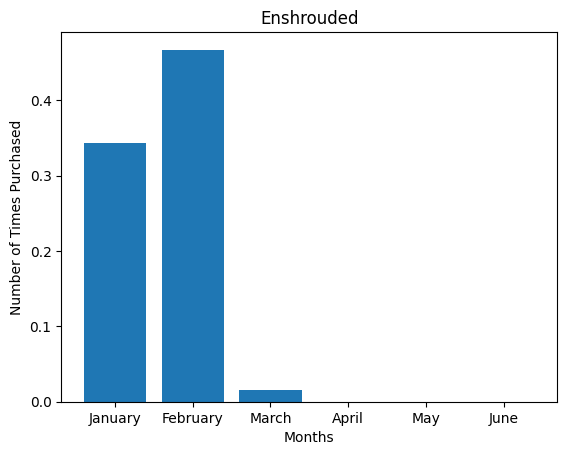

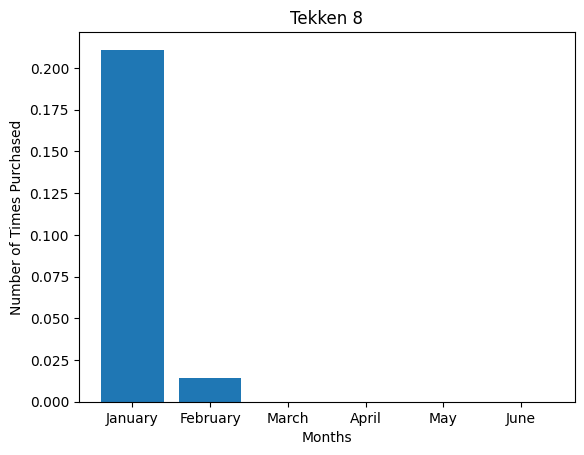

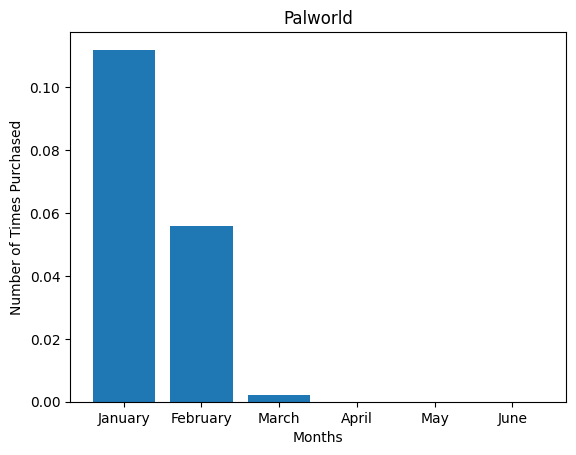

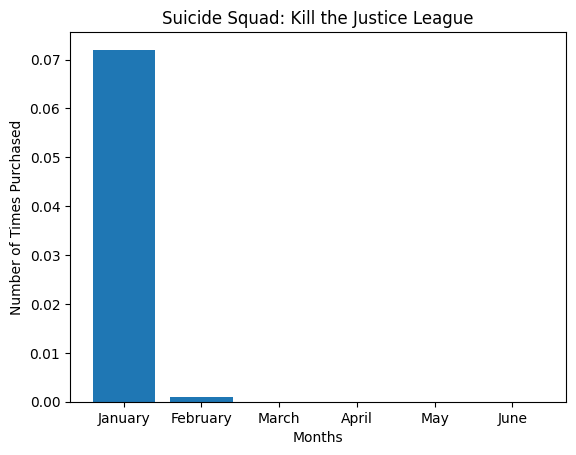

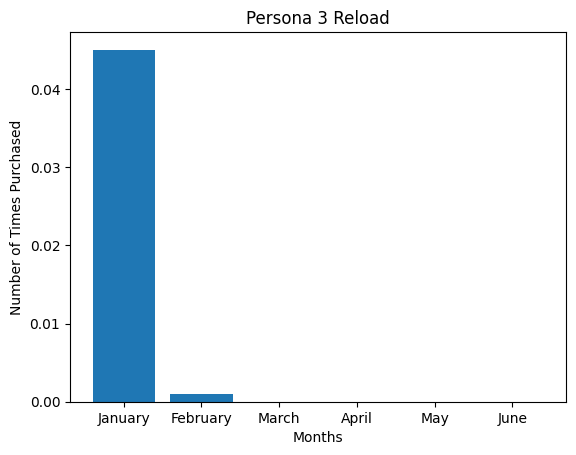

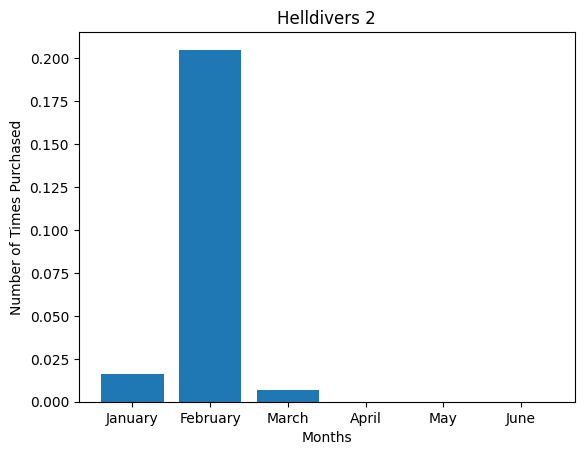

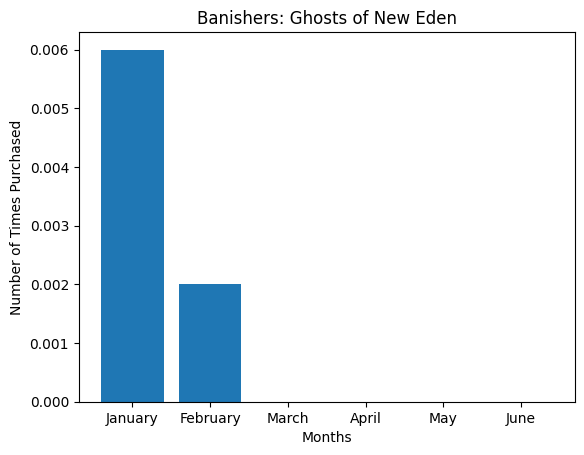

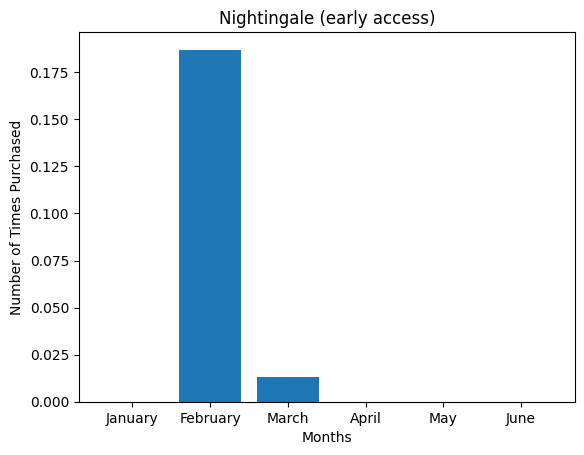

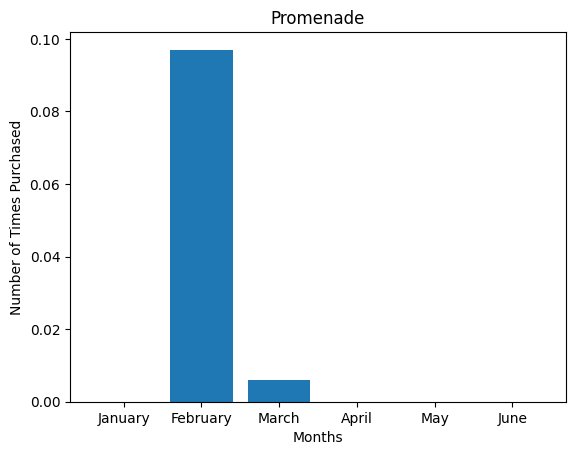

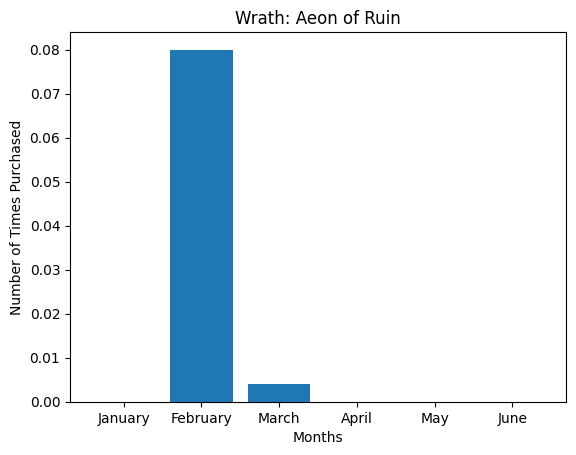

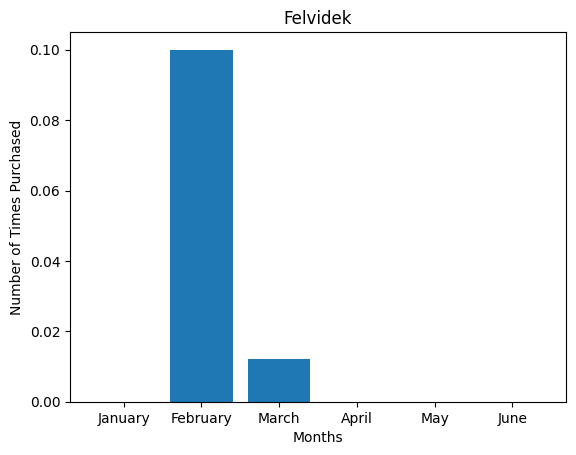

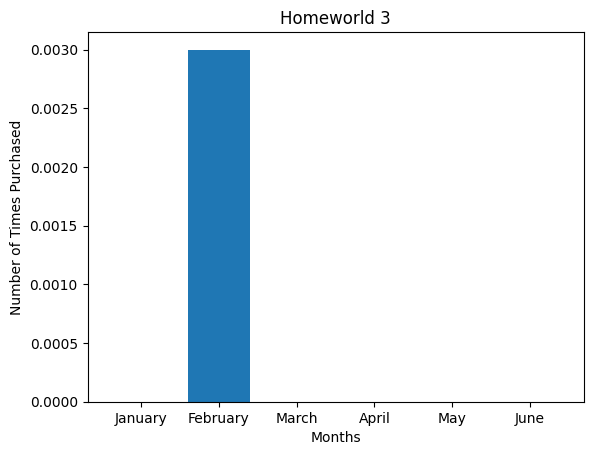

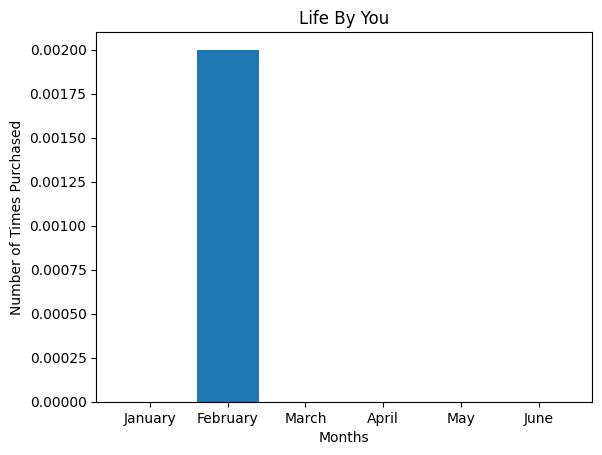

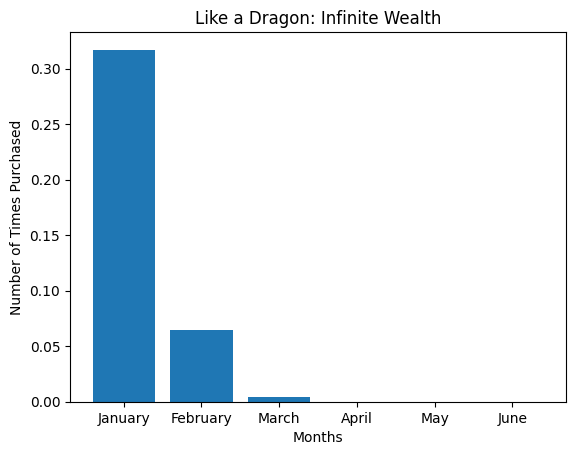

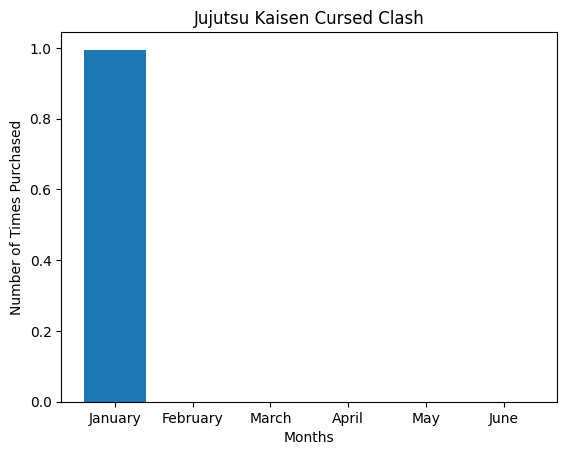

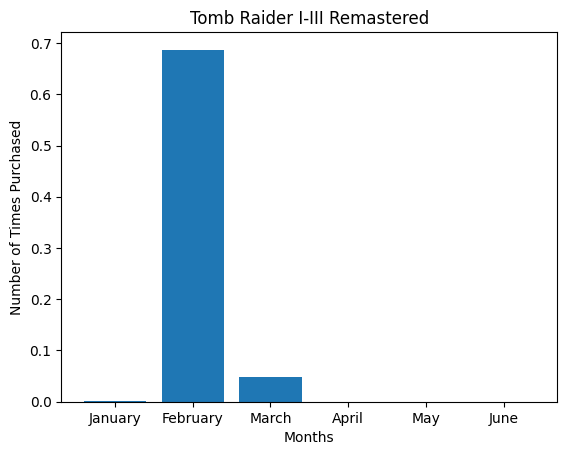

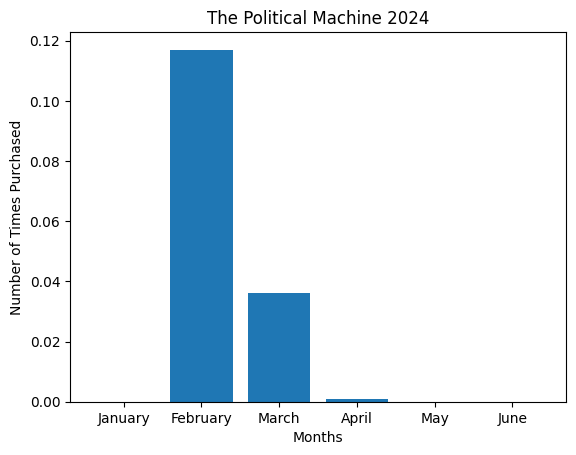

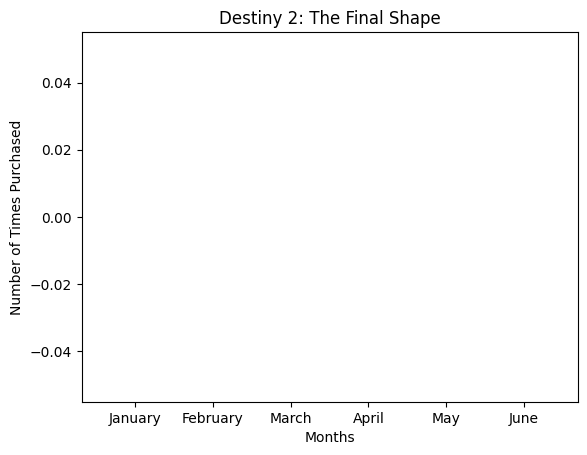

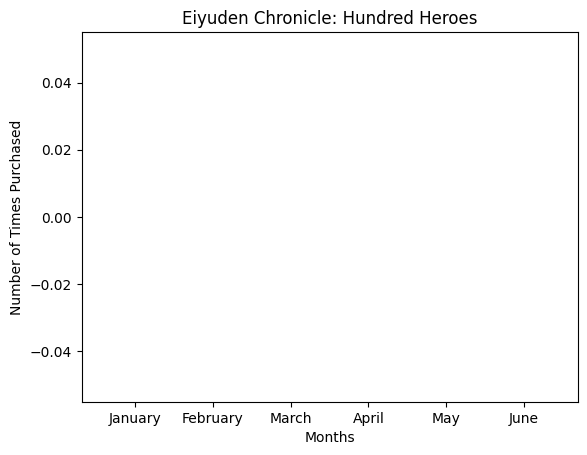

In [ ]:
for i in range(len(gamePurchasedMonthlyList)):
  plt.figure()
  plt.bar(monthList,gamePurchasedMonthlyList[i][1])
  plt.title(gamePurchasedMonthlyList[i][0])
  plt.xlabel("Months")
  plt.ylabel("Number of Times Purchased")
  plt.show()
plt.show()

In [ ]:
def monthlyKnapsackIPWithCoefficients(gamesMonthly, alpha, beta, omega):
  objective = 0
  cashAtHand = 20000
  optimalSolutions = []
  for month in range(len(gamesMonthly)):
    if month < 3:
      alpha = alpha*2
      beta = 0
      omega = 0
    elif month >= 3:
      alpha = 0
      beta = beta*2
      omega = omega*2
    monthlyGamesMetacritic, monthlyGamesEnjoyment, monthlySimilarityList, monthlyPriceList, monthlyNames = [], [], [], [], []
    for game in gamesMonthly[month]:
      monthlyGamesMetacritic.append(ReleasingGamesMetacritic[game]), monthlyGamesEnjoyment.append(ReleasingGamesEnjoyment[game]), monthlySimilarityList.append(SimilarityList[game]), monthlyPriceList.append(PriceList[game]), monthlyNames.append(GameNames[game])
    obj, cost, optimalSolution = initialIP(monthlyGamesMetacritic, monthlyGamesEnjoyment, monthlySimilarityList, monthlyPriceList, cashAtHand, len(monthlyPriceList), True, monthlyNames, alpha, beta, omega)
    cashAtHand = cashAtHand-cost
    objective = objective+obj
    optimalSolutions.append(optimalSolution)
  return objective, optimalSolutions

In [ ]:
# Scenario: From January to March, the gamer has exams/business so prefers to maximize similarity, but from April to June, the gamer prefers enjoyment and metacritic scroes more, as there is more freetime

monthlyKnapsackIPWithCoefficients(gamesEachMonth, 5, 0.5, 1)

Jujutsu Kaisen Cursed Clash: Buy
Enshrouded: Buy
Tekken 8: Don't Buy
Palworld: Don't Buy
Suicide Squad: Kill the Justice League: Don't Buy
Persona 3 Reload: Don't Buy
Helldivers 2: Don't Buy
Banishers: Ghosts of New Eden: Buy
Like a Dragon: Infinite Wealth: Don't Buy
Tomb Raider I-III Remastered: Buy
Nightingale (early access): Don't Buy
Promenade: Don't Buy
Wrath: Aeon of Ruin: Don't Buy
Felvidek: Don't Buy
Homeworld 3: Don't Buy
Life By You: Don't Buy
The Political Machine 2024: Buy
Destiny 2: The Final Shape: Don't Buy
Eiyuden Chronicle: Hundred Heroes: Don't Buy


(26.511137788168067,
 [[['Jujutsu Kaisen Cursed Clash', 1.0]],
  [['Enshrouded', 1.0],
   ['Tekken 8', 0.0],
   ['Palworld', 0.0],
   ['Suicide Squad: Kill the Justice League', 0.0],
   ['Persona 3 Reload', 0.0],
   ['Helldivers 2', 0.0],
   ['Banishers: Ghosts of New Eden', 1.0],
   ['Like a Dragon: Infinite Wealth', 0.0],
   ['Tomb Raider I-III Remastered', 1.0]],
  [['Nightingale (early access)', 0.0],
   ['Promenade', 0.0],
   ['Wrath: Aeon of Ruin', 0.0],
   ['Felvidek', 0.0],
   ['Homeworld 3', 0.0],
   ['Life By You', 0.0],
   ['The Political Machine 2024', 1.0],
   ['Destiny 2: The Final Shape', 0.0]],
  [],
  [['Eiyuden Chronicle: Hundred Heroes', -0.0]]])

In [ ]:
objectivesCoef, optimalSolutionsCoef = [], []
nTrials = 1000
for i in range(nTrials):
  daysLeftSimulationCoef = []
  for days in daysLeft:
    daysLeftSimulationCoef.append(np.random.poisson(days))
  monthsLeftSimulationCoef = [math.floor(number/30) for number in daysLeftSimulationCoef]
  alpha = np.random.normal(5, 0.5)
  beta =  np.random.normal(0.5, 0.05)
  omega = np.random.normal(1, 0.1)
  gamesEachMonthSimulationCoef = []
  for i in range(min(monthsLeftSimulationCoef), max(monthsLeftSimulationCoef)+1):
    monthGamesSimulationCoef = []
    for j in range(len(monthsLeftSimulationCoef)):
      if monthsLeftSimulationCoef[j] == i:
        monthGamesSimulationCoef.append(j)
    gamesEachMonthSimulationCoef.append(monthGamesSimulationCoef)
  objectiveCoef, optimalSolutionCoef = monthlyKnapsackIPWithCoefficients(gamesEachMonthSimulationCoef, alpha, beta, omega)
  objectivesCoef.append(objectiveCoef), optimalSolutionsCoef.append(optimalSolutionCoef)

solutions = []
for solutionSet in optimalSolutionsCoef:
  for monthlySet in solutionSet:
    solutions.append(len(solutionSet))
maxMonths = max(solutions)

gamePurchasedMonthlyListCoef = []
for i in range(len(GameNames)):
  gamePurchasedMonthlyListCoef.append([GameNames[i], []])
  for j in range(maxMonths):
    gamePurchasedMonthlyListCoef[i][1].append(0)

Streaming output truncated to the last 5000 lines.
The Political Machine 2024: Don't Buy
Destiny 2: The Final Shape: Don't Buy
Eiyuden Chronicle: Hundred Heroes: Don't Buy
Palworld: Buy
Like a Dragon: Infinite Wealth: Buy
Jujutsu Kaisen Cursed Clash: Buy
Enshrouded: Don't Buy
Tekken 8: Don't Buy
Suicide Squad: Kill the Justice League: Don't Buy
Persona 3 Reload: Don't Buy
Helldivers 2: Don't Buy
Nightingale (early access): Don't Buy
Wrath: Aeon of Ruin: Don't Buy
Homeworld 3: Don't Buy
Tomb Raider I-III Remastered: Buy
Banishers: Ghosts of New Eden: Don't Buy
Promenade: Don't Buy
Felvidek: Don't Buy
Life By You: Don't Buy
The Political Machine 2024: Don't Buy
Destiny 2: The Final Shape: Don't Buy
Eiyuden Chronicle: Hundred Heroes: Don't Buy
Jujutsu Kaisen Cursed Clash: Buy
Enshrouded: Buy
Tekken 8: Don't Buy
Palworld: Buy
Suicide Squad: Kill the Justice League: Don't Buy
Persona 3 Reload: Don't Buy
Helldivers 2: Buy
Banishers: Ghosts of New Eden: Don't Buy
Wrath: Aeon of Ruin: Buy
Like

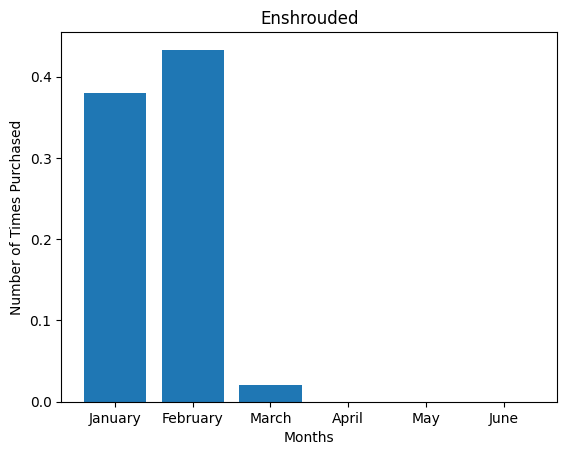

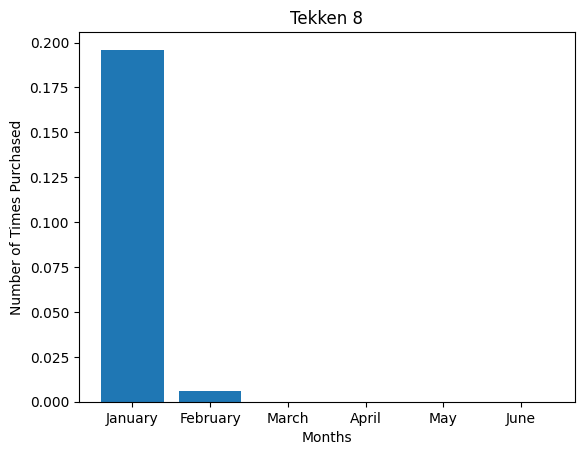

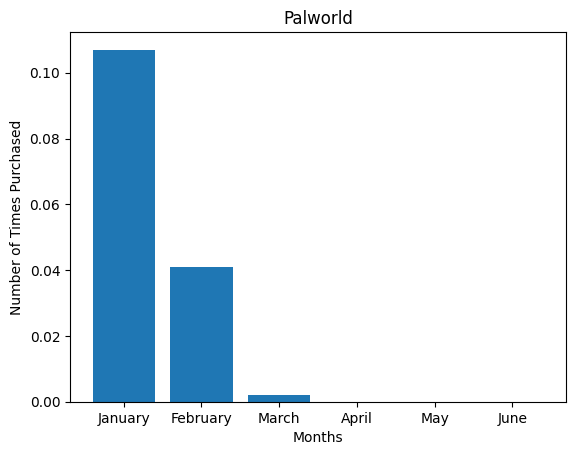

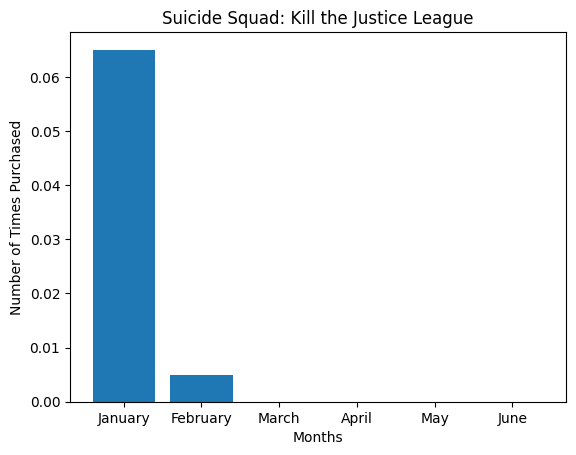

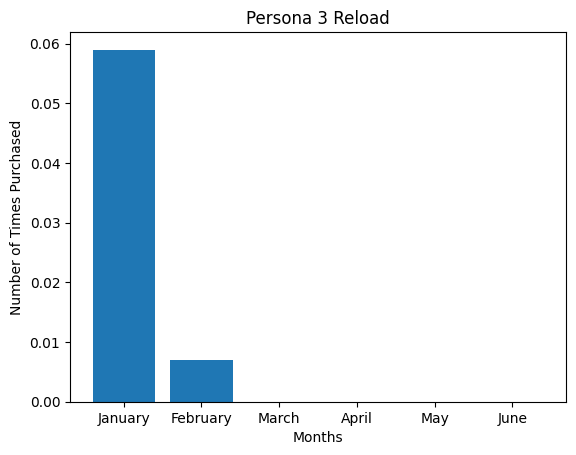

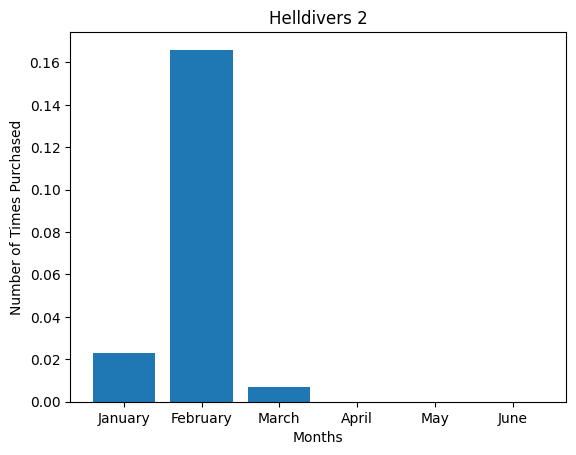

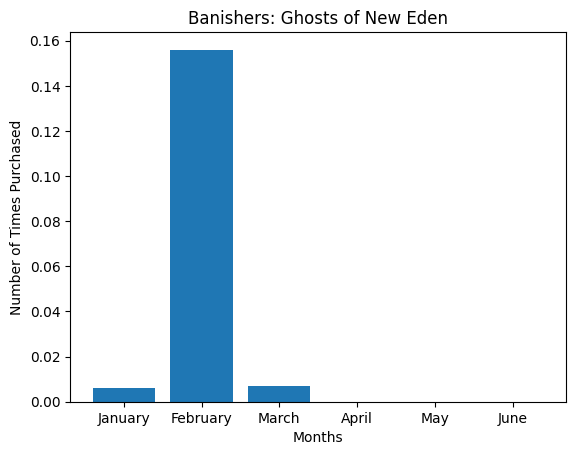

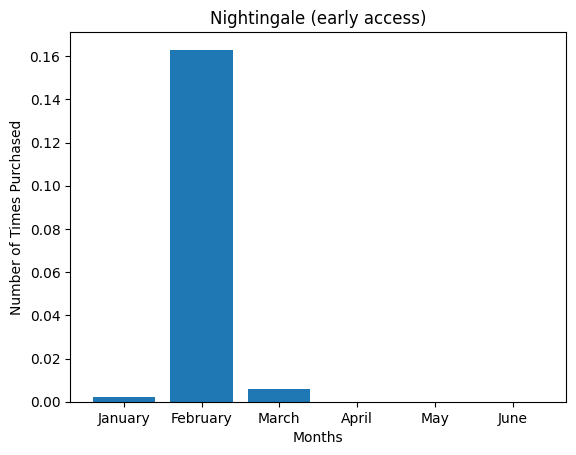

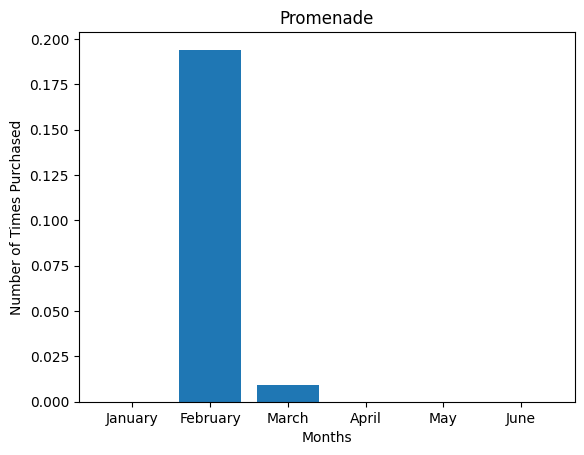

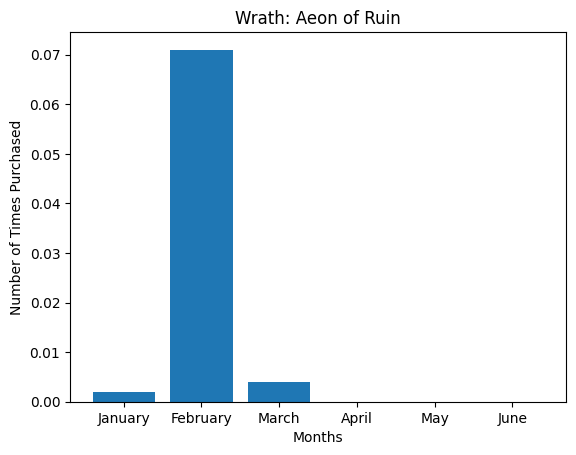

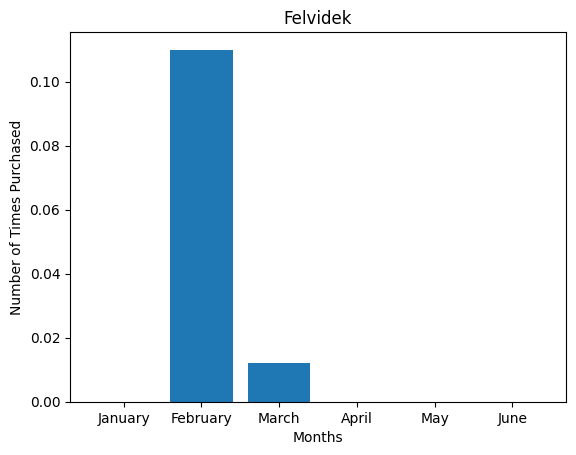

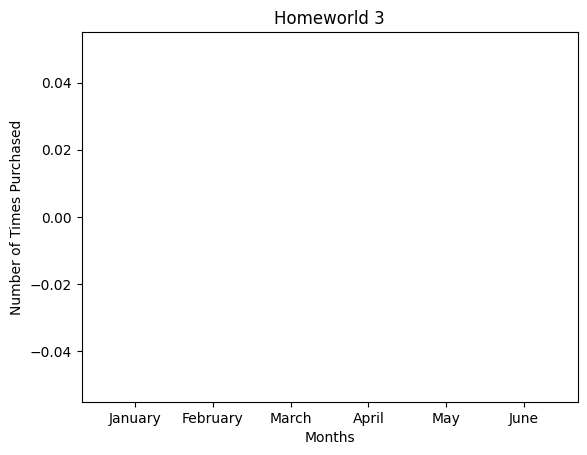

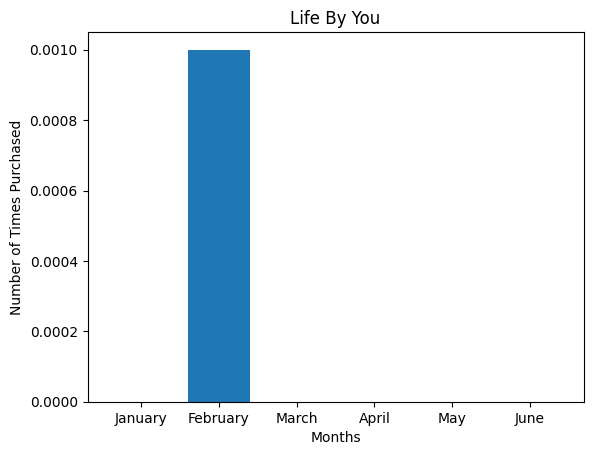

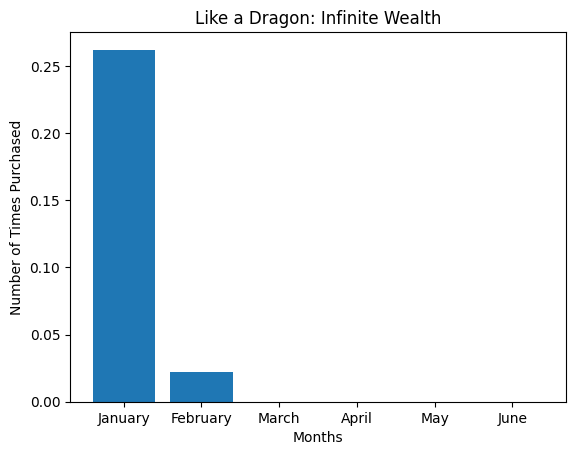

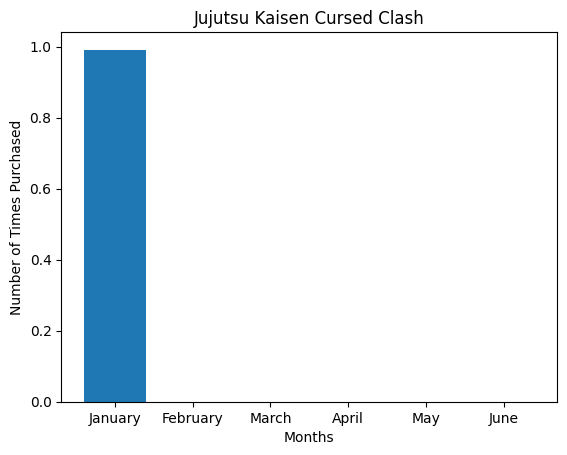

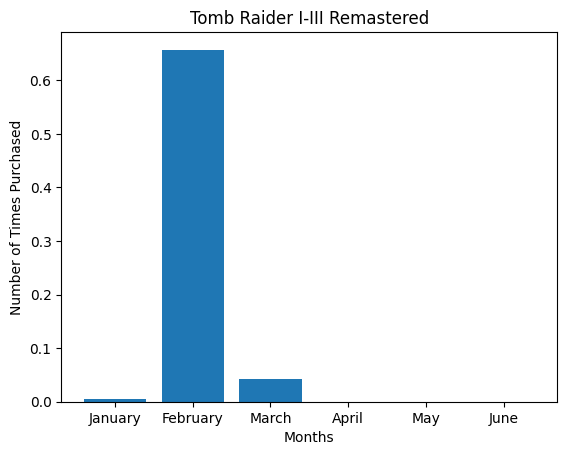

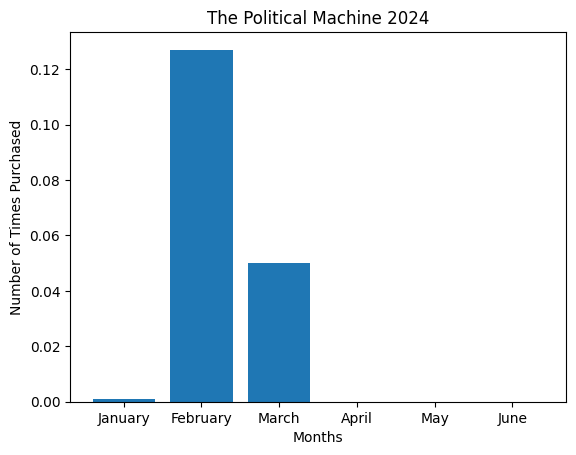

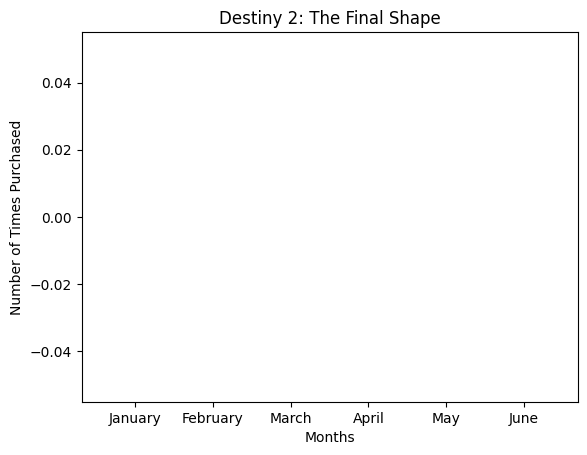

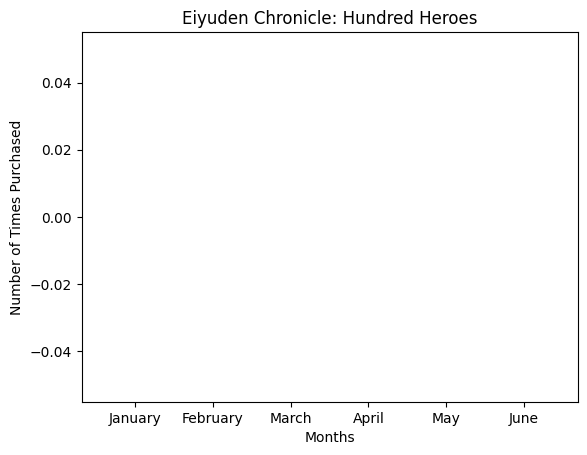

In [ ]:
for i in range(len(optimalSolutionsCoef)):
  for j in range(len(optimalSolutionsCoef[i])): # j is the month
    for k in range(len(optimalSolutionsCoef[i][j])): # k is the game
      for l in range(len(gamePurchasedMonthlyListCoef)):
        if optimalSolutionsCoef[i][j][k][0] == gamePurchasedMonthlyListCoef[l][0]:
          num = gamePurchasedMonthlyListCoef[l][1][j]
          gamePurchasedMonthlyListCoef[l][1][j] = num + optimalSolutionsCoef[i][j][k][1]
gamePurchasedMonthlyPercentages = gamePurchasedMonthlyListCoef.copy()
for i in range(len(gamePurchasedMonthlyListCoef)):
  for j in range(len(gamePurchasedMonthlyListCoef[i][1])):
    gamePurchasedMonthlyPercentages[i][1][j] = gamePurchasedMonthlyListCoef[i][1][j]/nTrials

monthNumList = list(range(maxMonths))
monthList = []
for num in monthNumList:
  monthList.append(calendar.month_name[num+1])

for i in range(len(gamePurchasedMonthlyListCoef)):
  plt.figure()
  plt.bar(monthList,gamePurchasedMonthlyListCoef[i][1])
  plt.title(gamePurchasedMonthlyListCoef[i][0])
  plt.xlabel("Months")
  plt.ylabel("Number of Times Purchased")
  plt.show()
plt.show()

In [ ]:
gamePurchasedMonthlyList

[['Enshrouded', [0.343, 0.467, 0.015, 0.0, 0.0, 0.0]],
 ['Tekken 8', [0.211, 0.014, 0.0, 0.0, 0.0, 0.0]],
 ['Palworld', [0.112, 0.056, 0.002, 0.0, 0.0, 0.0]],
 ['Suicide Squad: Kill the Justice League',
  [0.072, 0.001, 0.0, 0.0, 0.0, 0.0]],
 ['Persona 3 Reload', [0.045, 0.001, 0.0, 0.0, 0.0, 0.0]],
 ['Helldivers 2', [0.016, 0.205, 0.007, 0.0, 0.0, 0.0]],
 ['Banishers: Ghosts of New Eden', [0.006, 0.002, 0.0, 0.0, 0.0, 0.0]],
 ['Nightingale (early access)', [0.0, 0.187, 0.013, 0.0, 0.0, 0.0]],
 ['Promenade', [0.0, 0.097, 0.006, 0.0, 0.0, 0.0]],
 ['Wrath: Aeon of Ruin', [0.0, 0.08, 0.004, 0.0, 0.0, 0.0]],
 ['Felvidek', [0.0, 0.1, 0.012, 0.0, 0.0, 0.0]],
 ['Homeworld 3', [0.0, 0.003, 0.0, 0.0, 0.0, 0.0]],
 ['Life By You', [0.0, 0.002, 0.0, 0.0, 0.0, 0.0]],
 ['Like a Dragon: Infinite Wealth', [0.317, 0.065, 0.004, 0.0, 0.0, 0.0]],
 ['Jujutsu Kaisen Cursed Clash', [0.995, 0.0, 0.0, 0.0, 0.0, 0.0]],
 ['Tomb Raider I-III Remastered', [0.002, 0.687, 0.049, 0.0, 0.0, 0.0]],
 ['The Political Ma

In [ ]:
for i in gamePurchasedMonthlyList:
  print(i[0]), print(sum(i[1]))

Enshrouded
0.8250000000000001
Tekken 8
0.225
Palworld
0.17
Suicide Squad: Kill the Justice League
0.073
Persona 3 Reload
0.046
Helldivers 2
0.22799999999999998
Banishers: Ghosts of New Eden
0.008
Nightingale (early access)
0.2
Promenade
0.10300000000000001
Wrath: Aeon of Ruin
0.084
Felvidek
0.112
Homeworld 3
0.003
Life By You
0.002
Like a Dragon: Infinite Wealth
0.386
Jujutsu Kaisen Cursed Clash
0.995
Tomb Raider I-III Remastered
0.7380000000000001
The Political Machine 2024
0.154
Destiny 2: The Final Shape
0.0
Eiyuden Chronicle: Hundred Heroes
0.0


In [ ]:
gamePurchasedMonthlyListCoef

[['Enshrouded', [0.38, 0.433, 0.021, 0.0, 0.0, 0.0]],
 ['Tekken 8', [0.196, 0.006, 0.0, 0.0, 0.0, 0.0]],
 ['Palworld', [0.107, 0.041, 0.002, 0.0, 0.0, 0.0]],
 ['Suicide Squad: Kill the Justice League',
  [0.065, 0.005, 0.0, 0.0, 0.0, 0.0]],
 ['Persona 3 Reload', [0.059, 0.007, 0.0, 0.0, 0.0, 0.0]],
 ['Helldivers 2', [0.023, 0.166, 0.007, 0.0, 0.0, 0.0]],
 ['Banishers: Ghosts of New Eden', [0.006, 0.156, 0.007, 0.0, 0.0, 0.0]],
 ['Nightingale (early access)', [0.002, 0.163, 0.006, 0.0, 0.0, 0.0]],
 ['Promenade', [0.0, 0.194, 0.009, 0.0, 0.0, 0.0]],
 ['Wrath: Aeon of Ruin', [0.002, 0.071, 0.004, 0.0, 0.0, 0.0]],
 ['Felvidek', [0.0, 0.11, 0.012, 0.0, 0.0, 0.0]],
 ['Homeworld 3', [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
 ['Life By You', [0.0, 0.001, 0.0, 0.0, 0.0, 0.0]],
 ['Like a Dragon: Infinite Wealth', [0.262, 0.022, 0.0, 0.0, 0.0, 0.0]],
 ['Jujutsu Kaisen Cursed Clash', [0.991, 0.0, 0.0, 0.0, 0.0, 0.0]],
 ['Tomb Raider I-III Remastered', [0.005, 0.657, 0.042, 0.0, 0.0, 0.0]],
 ['The Political

In [ ]:
for i in gamePurchasedMonthlyListCoef:
  print(i[0]), print(sum(i[1]))

Enshrouded
0.834
Tekken 8
0.202
Palworld
0.15
Suicide Squad: Kill the Justice League
0.07
Persona 3 Reload
0.066
Helldivers 2
0.196
Banishers: Ghosts of New Eden
0.169
Nightingale (early access)
0.171
Promenade
0.203
Wrath: Aeon of Ruin
0.077
Felvidek
0.122
Homeworld 3
0.0
Life By You
0.001
Like a Dragon: Infinite Wealth
0.28400000000000003
Jujutsu Kaisen Cursed Clash
0.991
Tomb Raider I-III Remastered
0.7040000000000001
The Political Machine 2024
0.178
Destiny 2: The Final Shape
0.0
Eiyuden Chronicle: Hundred Heroes
0.0
